In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [19]:
import addict
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple
from scipy.interpolate import RBFInterpolator
from matplotlib import path
import matplotlib
import matplotlib.patches as mpatches
from scipy.spatial import distance
import cm_xml_to_matplotlib as make_cmap

import celeri

plt.rcParams["text.usetex"] = False


In [3]:
# Utility functions
n_grid_x = 500
n_grid_y = 500

def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)

def rbf_interpolate():
    # Observation coordinates and data
    x_vec = np.linspace(231, 239, n_grid_x)
    y_vec = np.linspace(38, 52, n_grid_y)
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    y_mat = y_mat
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    centroids_val = fill_value

    # Package for RBFInterpolator
    xgrid = np.stack((x_mat, y_mat))
    xflat = xgrid.reshape(2, -1).T
    xobs = np.vstack((centroids_lon, centroids_lat)).T
    yobs = centroids_val
    yflat = RBFInterpolator(xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5)(
        xflat
    )
    ygrid = yflat.reshape(n_grid_x, n_grid_y)
    return xgrid, ygrid

In [4]:
COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)


2022-08-30 22:57:28.220 | INFO     | celeri.celeri:get_logger:108 - Read: ../data/command/western_north_america_command.json
2022-08-30 22:57:28.221 | INFO     | celeri.celeri:get_logger:109 - RUN_NAME: 2022-08-30-22-57-28
2022-08-30 22:57:28.222 | INFO     | celeri.celeri:get_logger:110 - Write log file: ../runs/2022-08-30-22-57-28/2022-08-30-22-57-28.log
2022-08-30 22:57:28.223 | INFO     | celeri.celeri:read_data:115 - Reading data files
2022-08-30 22:57:28.231 | SUCCESS  | celeri.celeri:read_data:119 - Read: ../data/segment/western_north_america_segment.csv
2022-08-30 22:57:28.235 | SUCCESS  | celeri.celeri:read_data:124 - Read: ../data/block/western_north_america_block.csv
2022-08-30 22:57:28.236 | SUCCESS  | celeri.celeri:read_data:131 - Read: ../data/mesh/western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2022-08-30 22:57:28.262 | SUCCESS  | celeri.celeri:read_data:237 - Read: ../data/mesh/cascadia.msh
2022-08-30 22:57:28.265 | SUCCESS  | celeri.celeri:read_data:273 - Read: ../data/station/western_north_america_station.csv
2022-08-30 22:57:28.266 | INFO     | celeri.celeri:read_data:288 - No mogi_file_name
2022-08-30 22:57:28.267 | INFO     | celeri.celeri:read_data:310 - No sar_file_name


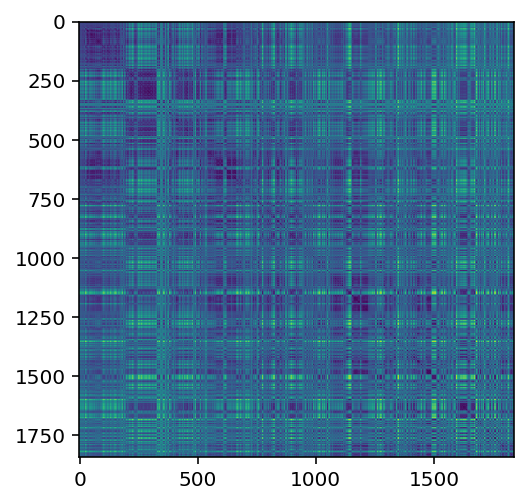

In [5]:
# Distance between mesh centroids
coords = np.vstack((meshes[0].x_centroid, meshes[0].y_centroid, meshes[0].z_centroid)).T
distance_matrix = distance.cdist(coords, coords, 'euclidean')
plt.figure()
plt.imshow(distance_matrix)
plt.show()

In [6]:
"""
Estimate the distance between subfaults i and j for every pair in the list
fault.subfaults.

:Inputs:
  -  *fault* of class dtopotools.Fault or some subclass,

:Outputs:
  - *D* array of Euclidean distances based on longitudes, latitudes, and depths
  - *Dstrike* array of estimated distances along strike direction
  - *Ddip* array of estimated distances along dip direction
with D**2 = Dstrike**2 + Ddip**2 to within roundoff.
  """


rad = np.pi / 180.0  # conversion factor from degrees to radians
rr = 6.378e6  # radius of earth
lat2meter = rr * rad  # conversion factor from degrees latitude to meters

nsubfaults = meshes[0].n_tde
D = np.zeros((nsubfaults, nsubfaults))
Dstrike = np.zeros((nsubfaults, nsubfaults))
Ddip = np.zeros((nsubfaults, nsubfaults))
# for i, si in enumerate(fault.subfaults):
for i in range(nsubfaults):
    xi = meshes[0].centroids[i, 0]
    yi = meshes[0].centroids[i, 1]
    zi = meshes[0].centroids[i, 2]
    # for j, sj in enumerate(fault.subfaults):
    for j in range(nsubfaults):
        xj = meshes[0].centroids[j, 0]
        yj = meshes[0].centroids[j, 1]
        zj = meshes[0].centroids[j, 2]
        dx = abs(xi - xj) * np.cos(0.5 * (yi + yj) * np.pi / 180.0) * lat2meter
        dy = abs(yi - yj) * lat2meter
        dz = abs(zi - zj)

        # Euclidean distance:
        D[i, j] = np.sqrt(dx**2 + dy**2 + dz**2)

        # estimate distance down-dip based on depths:
        dip = 0.5 * (meshes[0].dip[i] + meshes[0].dip[j])
        ddip1 = dz / np.sin(dip * np.pi / 180.0)
        Ddip[i, j] = ddip1
        if Ddip[i, j] > D[i, j]:
            # should not happen...
            if 0:
                print("i,j,dx,dy,dz: ", i, j, dx, dy, dz)
                print("*** Ddip = %s, D = %s" % (Ddip[i, j], D[i, j]))

        # compute distance in strike direction to sum up properly:
        dstrike2 = max(D[i, j] ** 2 - Ddip[i, j] ** 2, 0.0)
        Dstrike[i, j] = np.sqrt(dstrike2)


In [7]:
# D, Dstrike, Ddip = compute_subfault_distances(new_fault)
# D = distance_matrix

# Build correlation matrix:
# Gaussian with correlation lengths Lstrike and Ldip:
Lstrike = 400e3
Ldip = 40e3

print("Correlation lengths: Lstrike = %g, Ldip = %g" % (Lstrike, Ldip))
r = np.sqrt((Dstrike / Lstrike) ** 2 + (Ddip / Ldip) ** 2)
C = np.exp(-r)

# Replace with:
# https://stackoverflow.com/questions/71346322/numpy-area-of-triangle-and-equation-of-a-plane-on-which-triangle-lies-on
# lengths = np.array([s.length for s in fault.subfaults])
# widths = np.array([s.width for s in fault.subfaults])
# areas = lengths * widths

# def normal(triangles):
#     # The cross product of two sides is a normal vector
#     return np.cross(
#         triangles[:, 1] - triangles[:, 0], triangles[:, 2] - triangles[:, 0], axis=1
#     )

# def area(triangles):
#     # The norm of the cross product of two sides is twice the area
#     return np.linalg.norm(normal(triangles), axis=1) / 2

# triangles =

areas = np.ones(meshes[0].n_tde)
total_area = sum(areas)
mu = 3e10

Mw_desired = 9.0
Mo_desired = 10.0 ** (1.5 * Mw_desired + 9.05)
mean_slip = Mo_desired / (mu * total_area)
print("mean_slip %g meters required for Mw %s" % (mean_slip, Mw_desired))

# Turn this into a constant vector:
mean_slip = mean_slip * np.ones(meshes[0].n_tde)
alpha = 0.5
sigma_slip = alpha * mean_slip

# Lognormal:
Cov_g = np.log((sigma_slip / mean_slip) * (C * (sigma_slip / mean_slip)).T + 1.0)
mean_slip_g = np.log(mean_slip) - np.diag(Cov_g) / 2.0

# This should be the same:
Cov_g = np.log(alpha**2 * C + 1.0)

# Find eigenvalues, and eigenvector matrix.
# Columns V[:,k] are eigenvectors.
print("Finding eigenmodes from %s by %s matrix C" % (meshes[0].n_tde, meshes[0].n_tde))
lam, V = np.linalg.eig(Cov_g)
eigenvals = np.real(lam)  # imaginary parts should be at rounding level
V = np.real(V)

# # Sort eigenvalues:
i = list(np.argsort(lam))
i.reverse()
lam = lam[i]
V = V[:, i]


Correlation lengths: Lstrike = 400000, Ldip = 40000
mean_slip 6.42429e+08 meters required for Mw 9.0
Finding eigenmodes from 1841 by 1841 matrix C


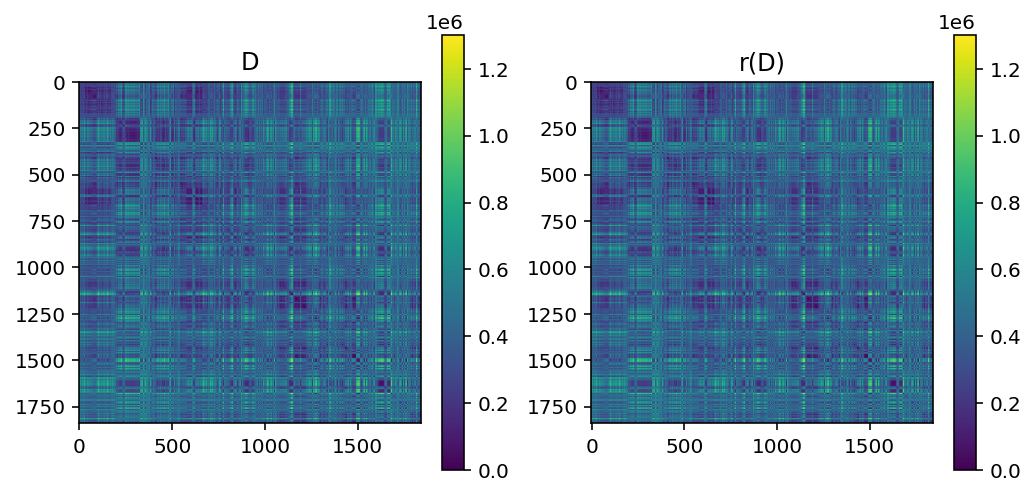

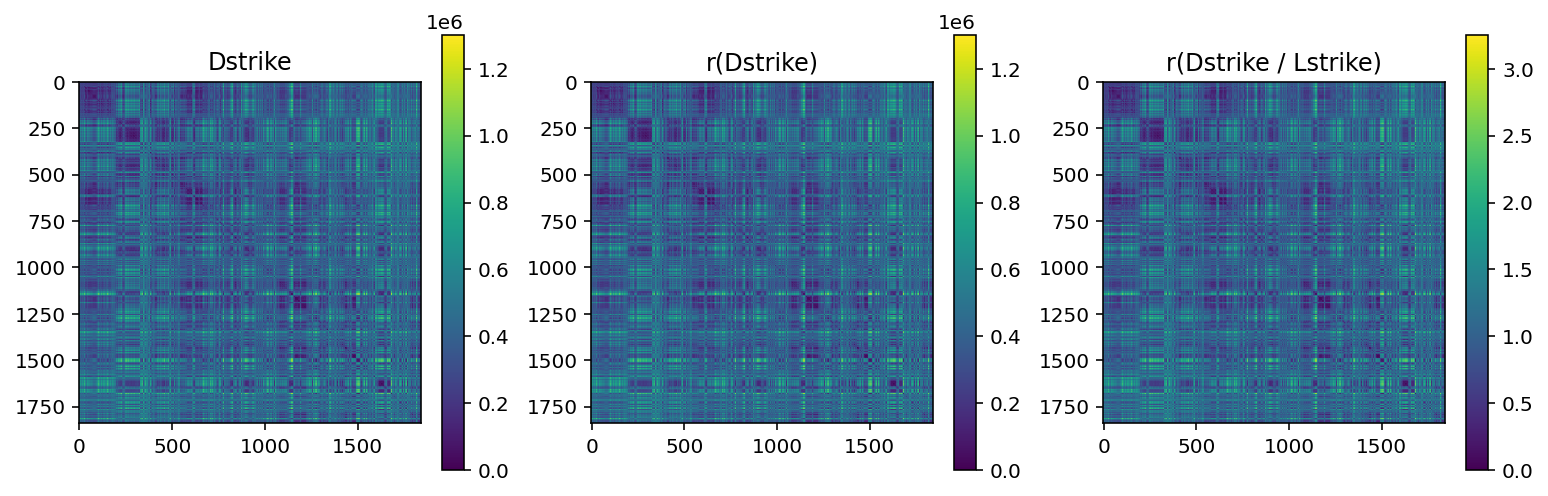

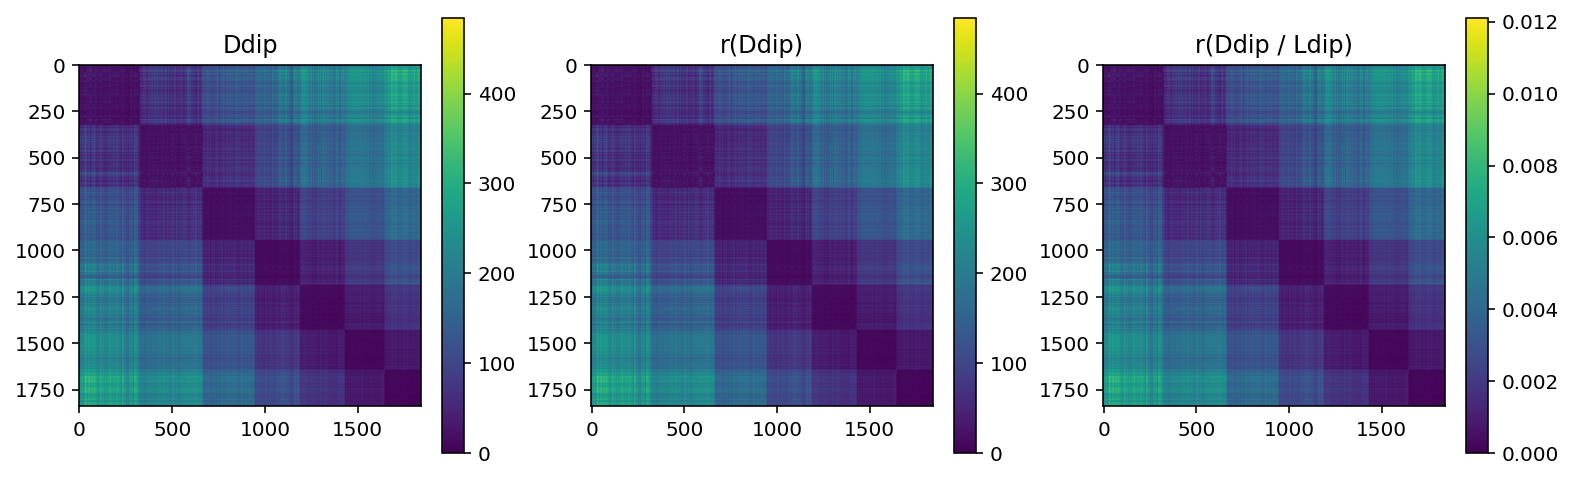

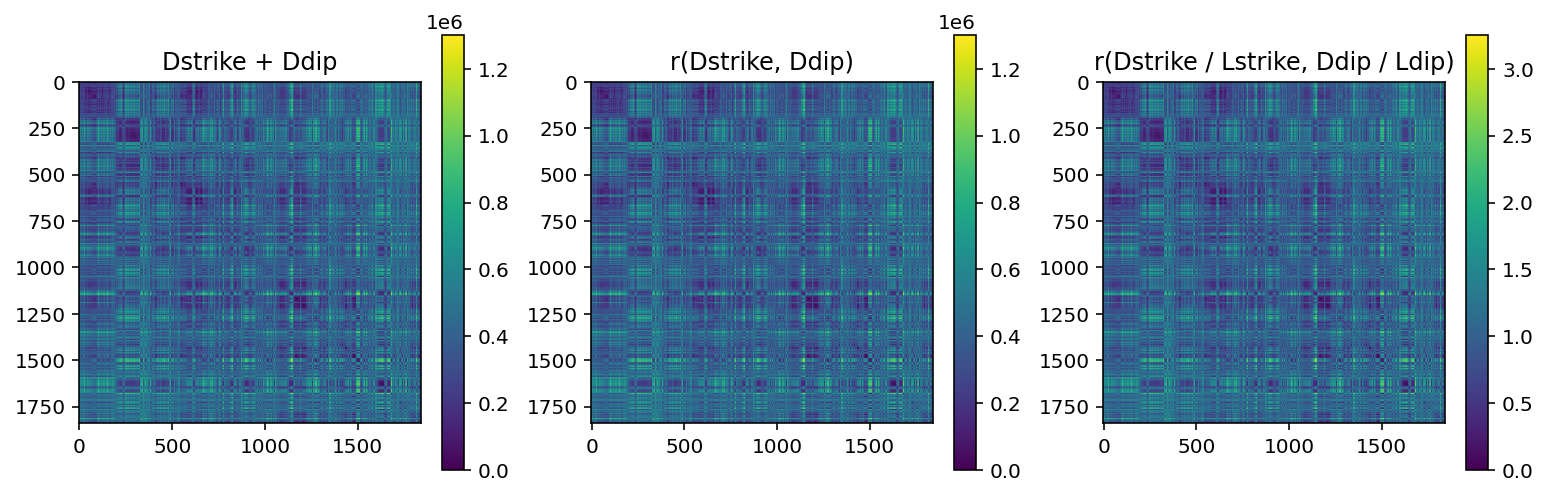

In [38]:
# Visualize difference in matrices
plt.figure(figsize=(13, 4))
plt.subplot(1, 3, 1)
plt.title("D")
plt.imshow(D)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("r(D)")
r = np.sqrt(D ** 2)
plt.imshow(r)
plt.colorbar()
plt.show()

plt.figure(figsize=(13, 4))
plt.subplot(1, 3, 1)
plt.title("Dstrike")
plt.imshow(Dstrike)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("r(Dstrike)")
r = np.sqrt(Dstrike ** 2)
plt.imshow(r)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("r(Dstrike / Lstrike)")
r = np.sqrt((Dstrike / Lstrike) ** 2)
plt.imshow(r)
plt.colorbar()
plt.show()

plt.figure(figsize=(13, 4))
plt.subplot(1, 3, 1)
plt.title("Ddip")
plt.imshow(Ddip)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("r(Ddip)")
r = np.sqrt(Ddip ** 2)
plt.imshow(r)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("r(Ddip / Ldip)")
r = np.sqrt((Ddip / Ldip) ** 2)
plt.imshow(r)
plt.colorbar()
plt.show()

plt.figure(figsize=(13, 4))
plt.subplot(1, 3, 1)
plt.title("Dstrike + Ddip")
plt.imshow(Dstrike + Ddip)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("r(Dstrike, Ddip)")
r = np.sqrt(Dstrike ** 2 + Ddip ** 2)
plt.imshow(r)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("r(Dstrike / Lstrike, Ddip / Ldip)")
r = np.sqrt((Dstrike / Lstrike) ** 2 + (Ddip / Ldip) ** 2)
plt.imshow(r)
plt.colorbar()
plt.show()


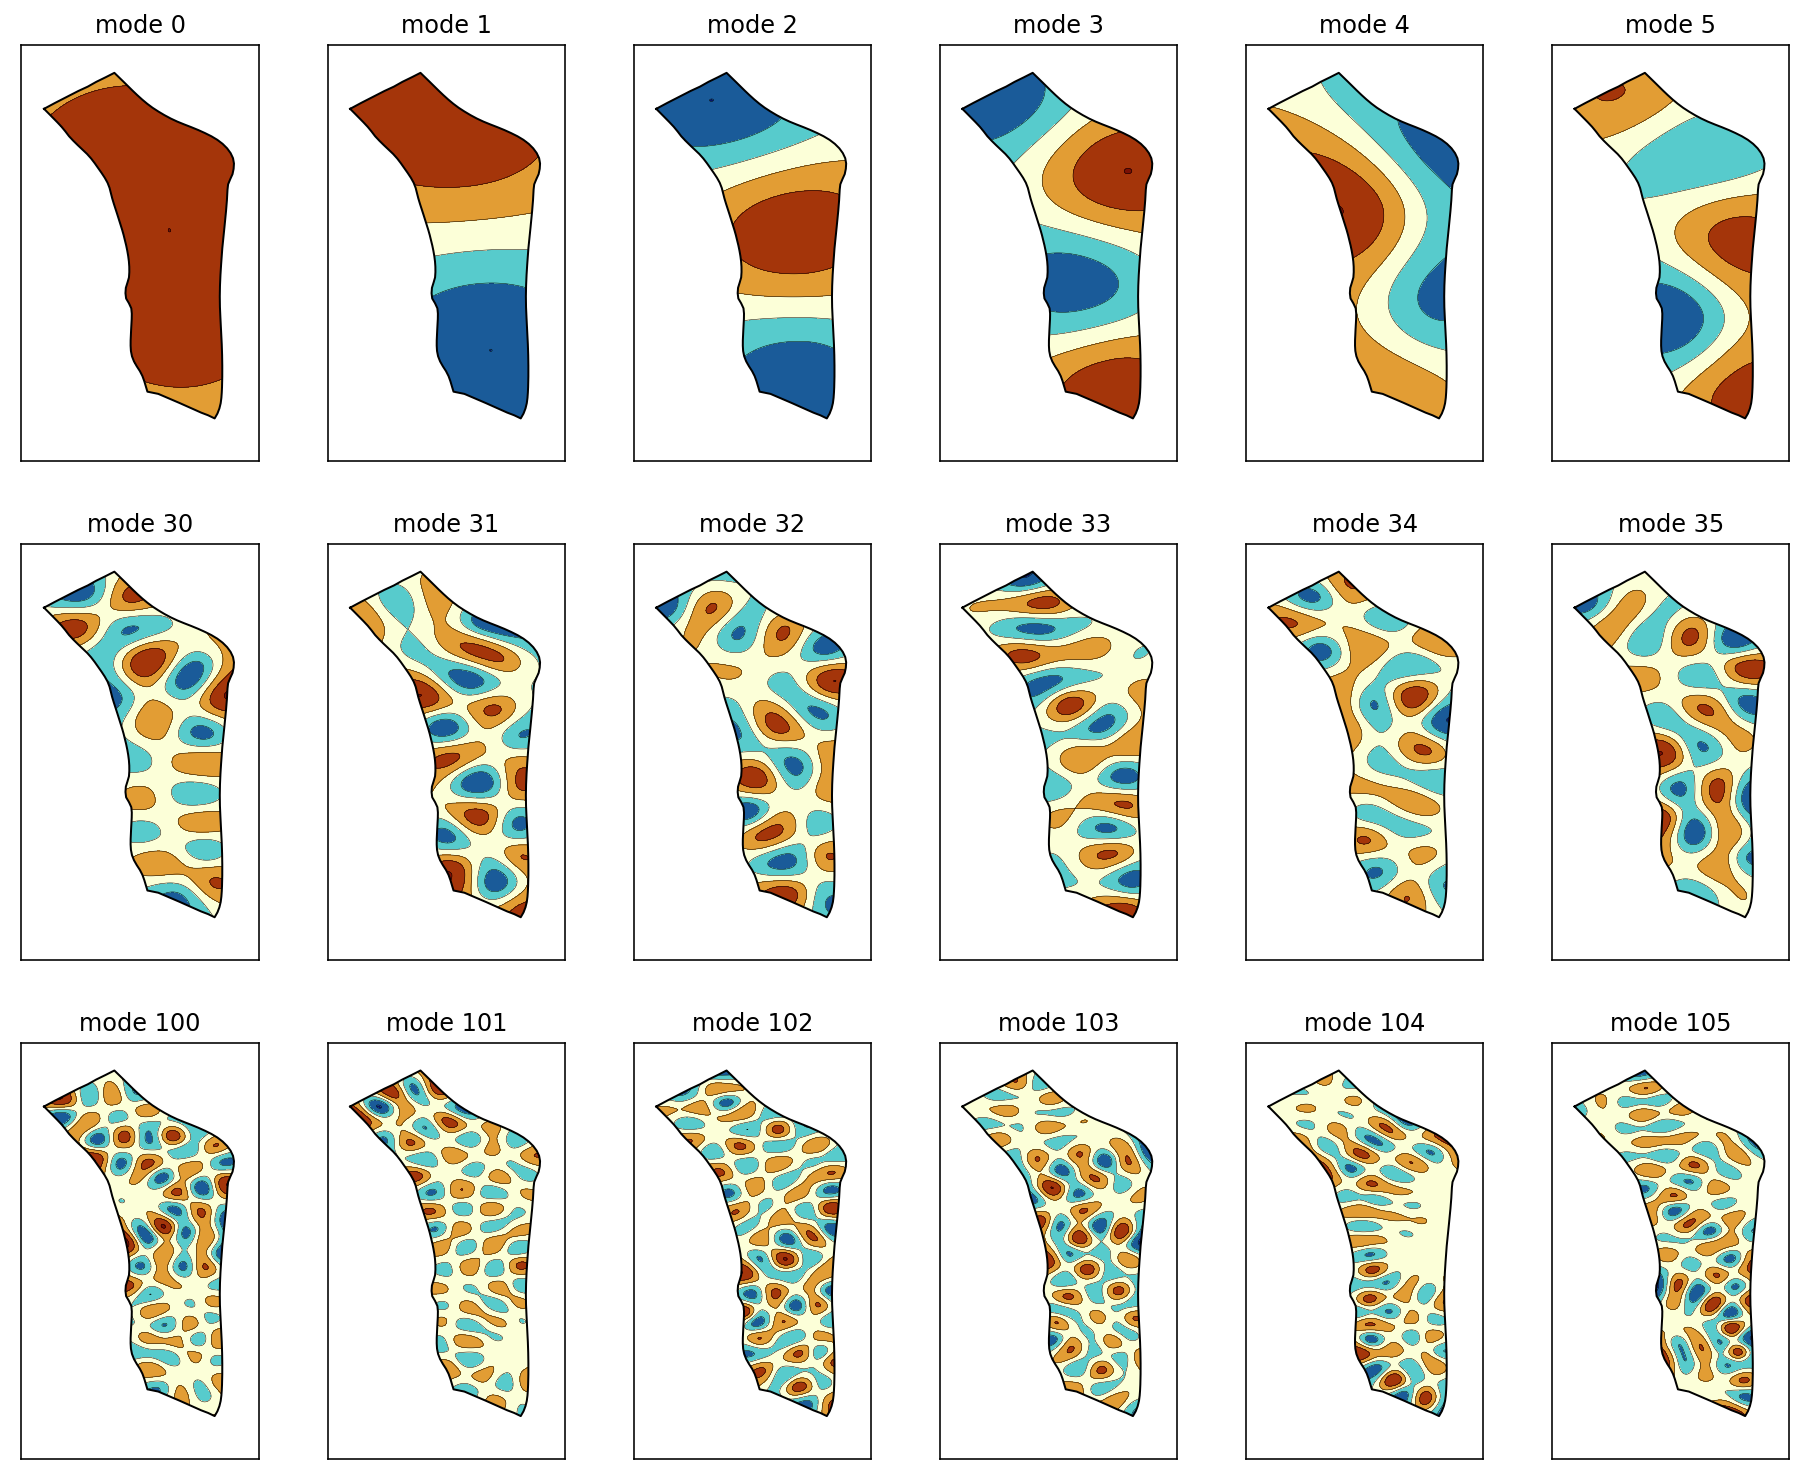

In [23]:
# Plot select eigenmodes
plt.figure(figsize=(16, 13))

cmap = make_cmap.make_cmap("w_ymiddle1.xml")

for i in range(0, 18):
    ax = plt.subplot(3, 6, i + 1)

    # Shift eigenmodes by plotting row to show some dynamic range
    if i > 5 and i <= 11:
        i = i - 6 + 30
    elif i > 11:
        i = i - 12 + 100
    fill_value = fill_value = V[:, i]

    # Normalize fill_value for interpretable plotting
    min_value = np.min(fill_value)
    max_value = np.max(fill_value)
    if np.abs(max_value) > np.abs(min_value):
        fill_value = fill_value / max_value
    else:
        fill_value = fill_value / np.abs(min_value)

    # Interpolate values onto a regular grid for plotting
    xgrid, ygrid = rbf_interpolate()
    xflat = xgrid.reshape(2, -1).T
    inpolygon_vals = inpolygon(
        xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
    ygrid[~inpolygon_vals] = np.nan

    # Plot
    levels = np.linspace(-1.0, 1.0, 6)
    plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
    plt.contour(
        *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
    )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"mode {i}")

plt.savefig("select_eigenmodes.pdf")
plt.savefig("select_eigenmodes.png", dpi=500)

plt.show()


In [11]:
print(D.shape)
print(Cov_g.shape)
print(lam.shape)
print(V.shape)
print(meshes[0].n_tde)
print("Finding eigenmodes from %s by %s matrix C" % (meshes[0].n_tde, meshes[0].n_tde))

(1841, 1841)
(1841, 1841)
(1841,)
(1841, 1841)
1841
Finding eigenmodes from 1841 by 1841 matrix C


In [46]:
max_depth = np.concatenate((-meshes[0].dep1, -meshes[0].dep2, -meshes[0].dep3)).max()
tau = lambda d: 1.0 - np.exp((-d - max_depth) * 70 / max_depth)


/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_60484/1032059417.py:69: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(pc)


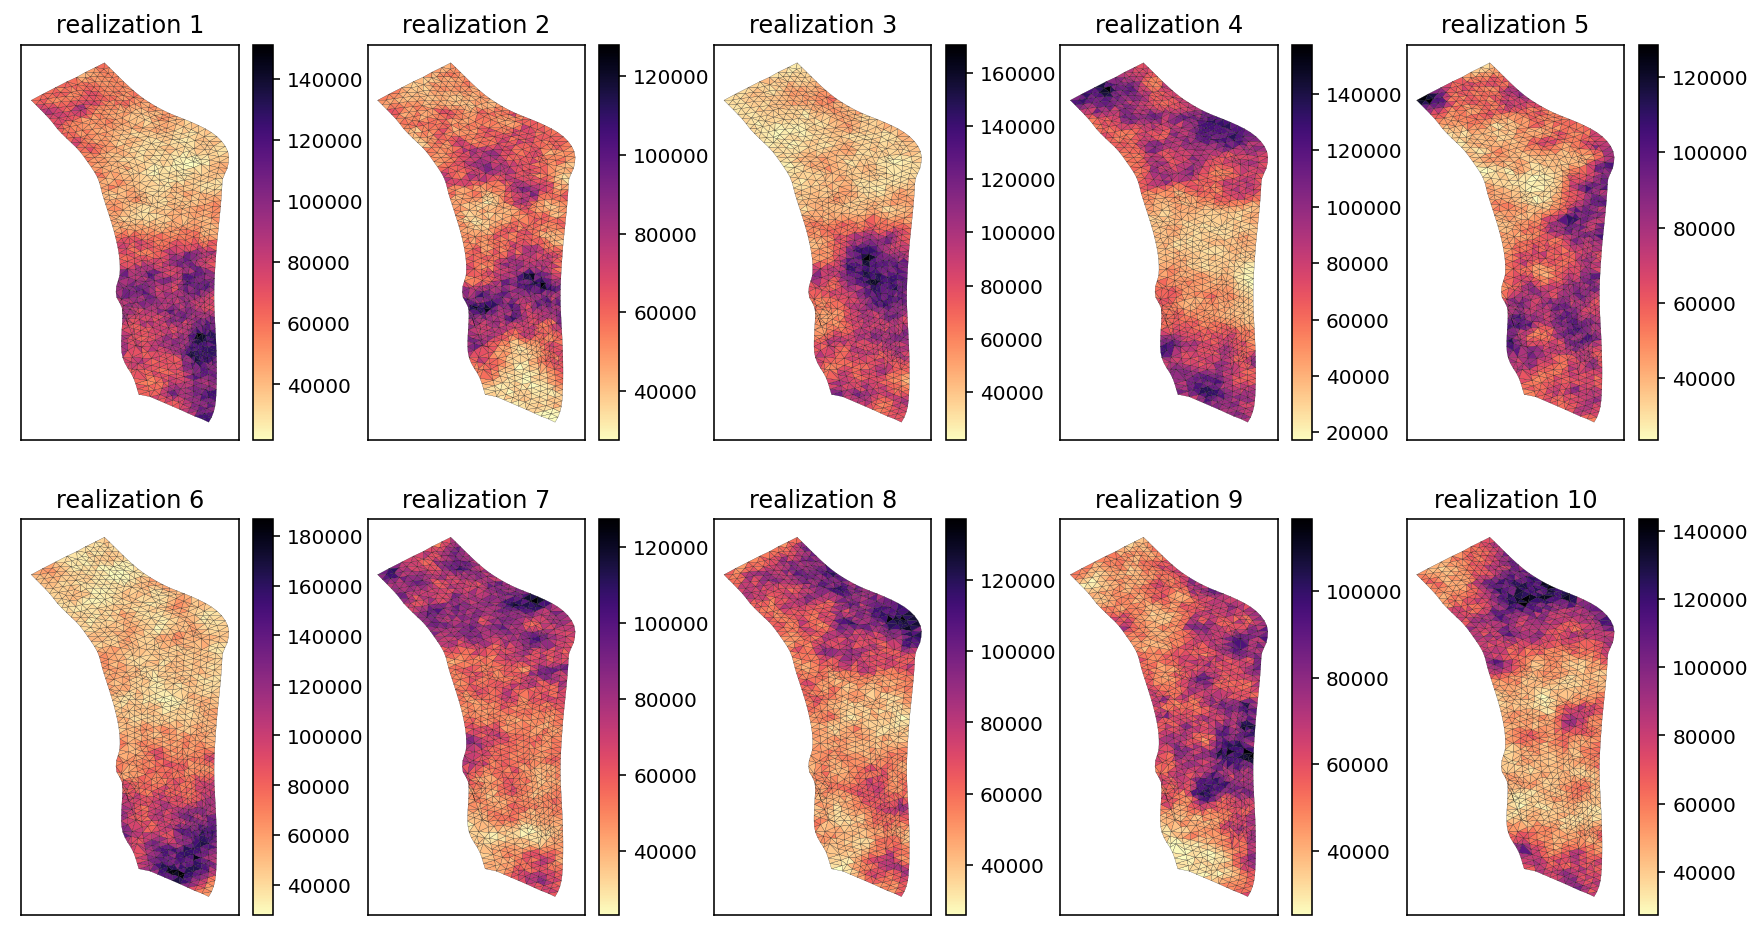

In [47]:
# Moment Magnitude (MW) = 2/3 log10(MO) - 10.7
Mo = 3e10 * 20e6


def KL(z):
    # TODO: Understand role of mean slip here
    # return KL_slip
    KL_slip = 0.0 * mean_slip_g.copy()  # drop the mean slip and rescale later
    # add in the terms in the K-L expansion:  (dropping V[:,0])
    for k in range(1, len(z)):
        KL_slip += z[k] * np.sqrt(lam[k]) * V[:, k]

    # Exponentiate to get Lognormal distribution:
    KL_slip = np.exp(KL_slip)

    # Rescale to have desired magnitude
    # TODO: Need correct fault areas for this to work
    # Mo = new_fault.Mo()
    KL_slip *= Mo_desired / Mo

    # Taper slip to go to zero at the base
    KL_slip *= tau(-meshes[0].centroids[:, 2])

    return KL_slip


nterms = 1841
x_coords = meshes[0].meshio_object.points[:, 0]
y_coords = meshes[0].meshio_object.points[:, 1]
vertex_array = np.asarray(meshes[0].verts)

plt.figure(figsize=(15, 8))
for i in range(0, 10):
    z = np.random.randn(nterms)
    KL_slip = KL(z)
    # KL_slip[KL_slip > 50000] = 0
    ax = plt.subplot(2, 5, i + 1)

    fill_value = KL_slip
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts,
        edgecolor="k",
        cmap="magma_r",
        linewidth=0.1,
        alpha=1.0,
    )
    pc.set_array(fill_value)
    plt.colorbar(pc)
    plt.xticks([])
    plt.yticks([])
    ax.add_collection(pc)
    ax.autoscale()
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"realization {i + 1}")

plt.show()


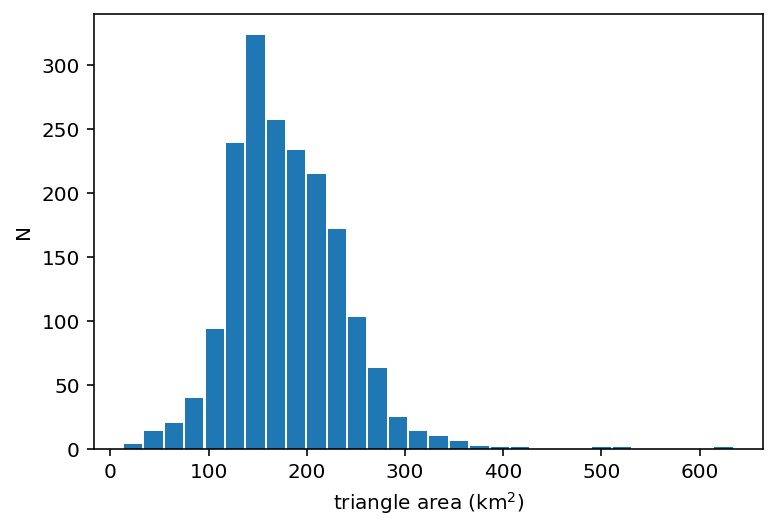

In [55]:
# Based on:
# https://stackoverflow.com/questions/71346322/numpy-area-of-triangle-and-equation-of-a-plane-on-which-triangle-lies-on

def triangle_normal(triangles):
    # The cross product of two sides is a normal vector
    return np.cross(
        triangles[:, 1] - triangles[:, 0], triangles[:, 2] - triangles[:, 0], axis=1
    )

def triangle_area(triangles):
    # The norm of the cross product of two sides is twice the area
    return np.linalg.norm(triangle_normal(triangles), axis=1) / 2

# Package triangle vertices
triangle_vertex_array = np.zeros((meshes[0].n_tde, 3, 3))
triangle_vertex_array[:, 0, 0] = meshes[0].x1
triangle_vertex_array[:, 1, 0] = meshes[0].x2
triangle_vertex_array[:, 2, 0] = meshes[0].x3
triangle_vertex_array[:, 0, 1] = meshes[0].y1
triangle_vertex_array[:, 1, 1] = meshes[0].y2
triangle_vertex_array[:, 2, 1] = meshes[0].y3
triangle_vertex_array[:, 0, 2] = meshes[0].z1
triangle_vertex_array[:, 1, 2] = meshes[0].z2
triangle_vertex_array[:, 2, 2] = meshes[0].z3

# Calculate triangle areas
triangle_areas = triangle_area(triangle_vertex_array)

# Plot frequency distribution of triangle areas
plt.hist(triangle_areas / 1e6, 30, rwidth=0.9)
plt.xlabel("triangle area (km$^2$)")
plt.ylabel("N")
plt.show()


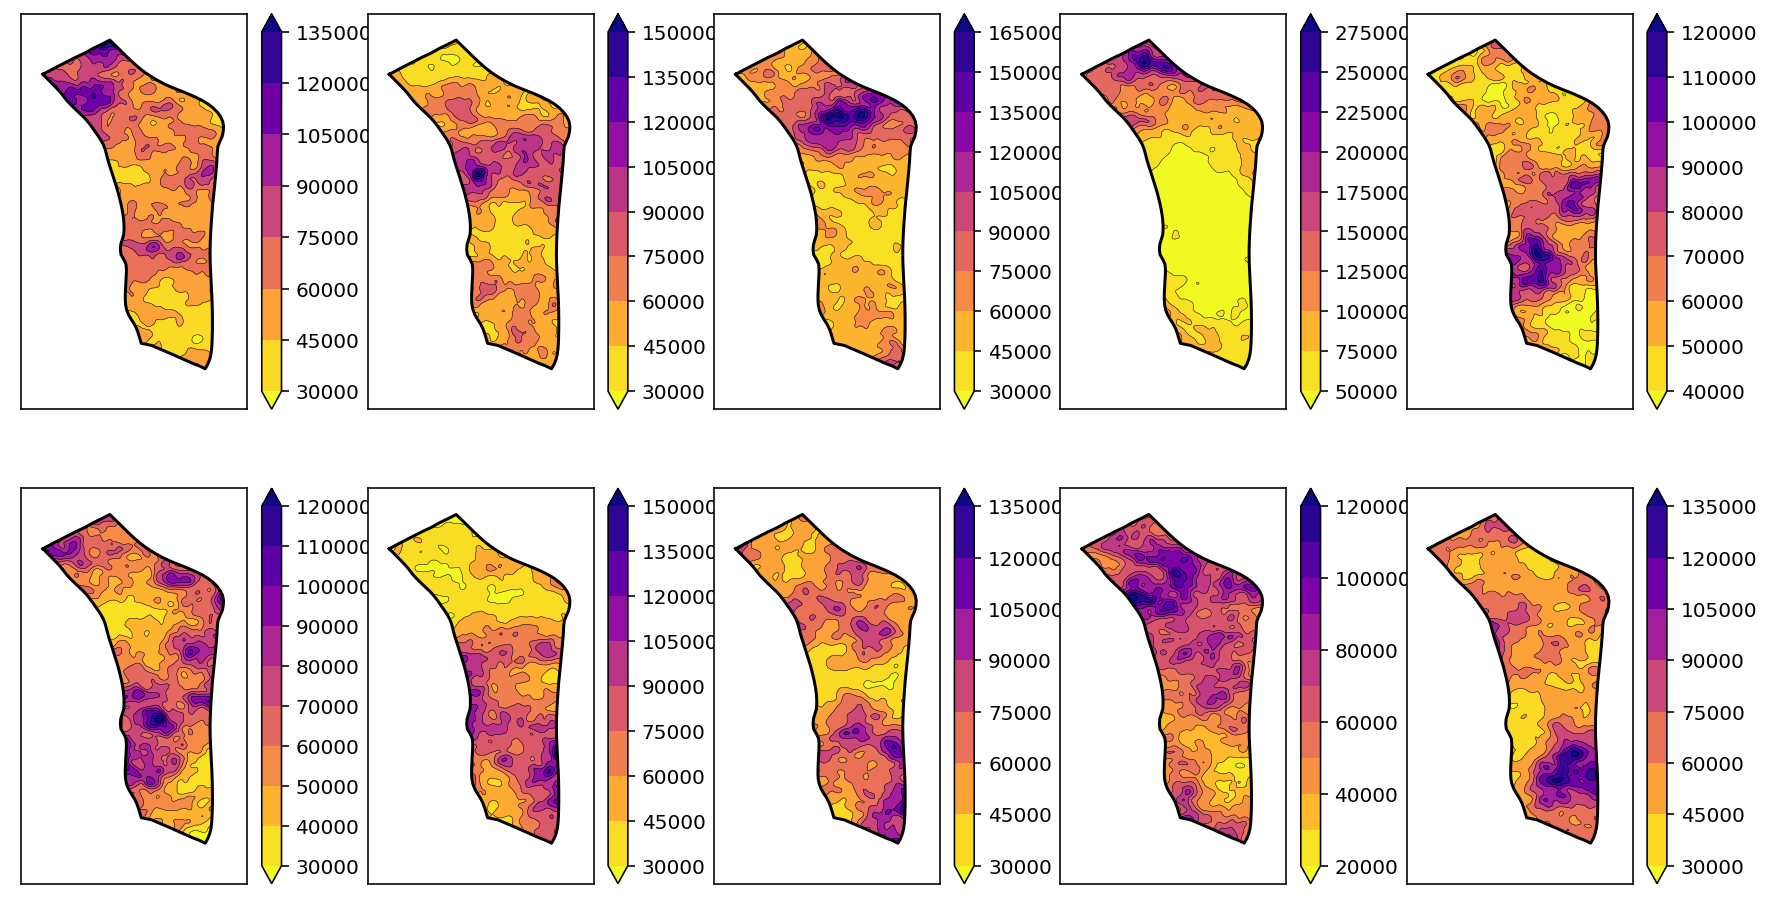

In [45]:
# Radial basis function interpolation
nterms = 1841
plt.figure(figsize=(15, 8))
for i in range(0, 10):
    z = np.random.randn(nterms)
    KL_slip = KL(z)
    # KL_slip[KL_slip > 50000] = 0
    ax = plt.subplot(2, 5, i + 1)

    fill_value = KL_slip
    xgrid, ygrid = rbf_interpolate()
    xflat = xgrid.reshape(2, -1).T
    inpolygon_vals = inpolygon(xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter)
    inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
    ygrid[~inpolygon_vals] = np.nan

    # Plot
    levels = 10

    # plt.figure(figsize=(20, 2))
    plt.contourf(*xgrid, ygrid, cmap="plasma_r", levels=levels, extend="both")
    # cbar = plt.colorbar()
    plt.contour(
        *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
    )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xticks([])
    plt.yticks([])

plt.savefig("slip_examples.pdf")
plt.savefig("slip_examples.png", dpi=500)


plt.show()


In [42]:
-meshes[0].centroids[:, 2]

array([ 0.62316357,  1.66636563,  3.04440643, ..., 66.66666667,
       66.66666667, 63.33333333])

In [17]:
levels

10